In [1]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas_ta as ta
import vectorbt as vbt
import pandas as pd

from datetime import datetime
from terminal.Extensions.MT5Helper import MT5Helper
from terminal.Extensions.Range import Range
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

c:\Users\agabo\miniconda3\envs\mt5jupyter\lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
c:\Users\agabo\miniconda3\envs\mt5jupyter\lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


In [2]:
mt5.initialize()

True

In [13]:
brick_size = 2

from_date = datetime(2024, 6, 7, tzinfo=pytz.utc)
to_date = datetime(from_date.year, 6, 7, 23, 59, 59, 0, tzinfo=pytz.utc)
data = mt5.copy_ticks_range('WDO$', from_date, to_date, mt5.COPY_TICKS_TRADE)

rates = MT5Helper.OHLC(data, '1s')
rates.index = rates.index.tz_localize(None)

rates["Open"] = rates["open"]
rates["Close"] = rates["close"]
rates["High"] = rates["high"]
rates["Low"] = rates["low"]

rates.dropna(inplace=True)

,type,Open,Close,High,Low
time,,,,,
2024-05-02 09:03:14,first,5173.0,5173.0,5271.0,5269.0
2024-05-02 09:03:18,down,5173.0,5171.0,5271.0,5269.0
2024-05-02 09:03:21,down,5171.0,5169.0,5271.0,5269.0
2024-05-02 09:03:30,down,5169.0,5167.0,5271.0,5269.0
2024-05-02 09:03:40,up,5167.0,5169.0,5271.0,5269.0
...,...,...,...,...,...
2024-06-06 17:49:07,up,5267.0,5269.0,5271.0,5269.0
2024-06-06 17:57:33,down,5269.0,5267.0,5271.0,5269.0
2024-06-06 17:59:46,up,5267.0,5269.0,5271.0,5269.0


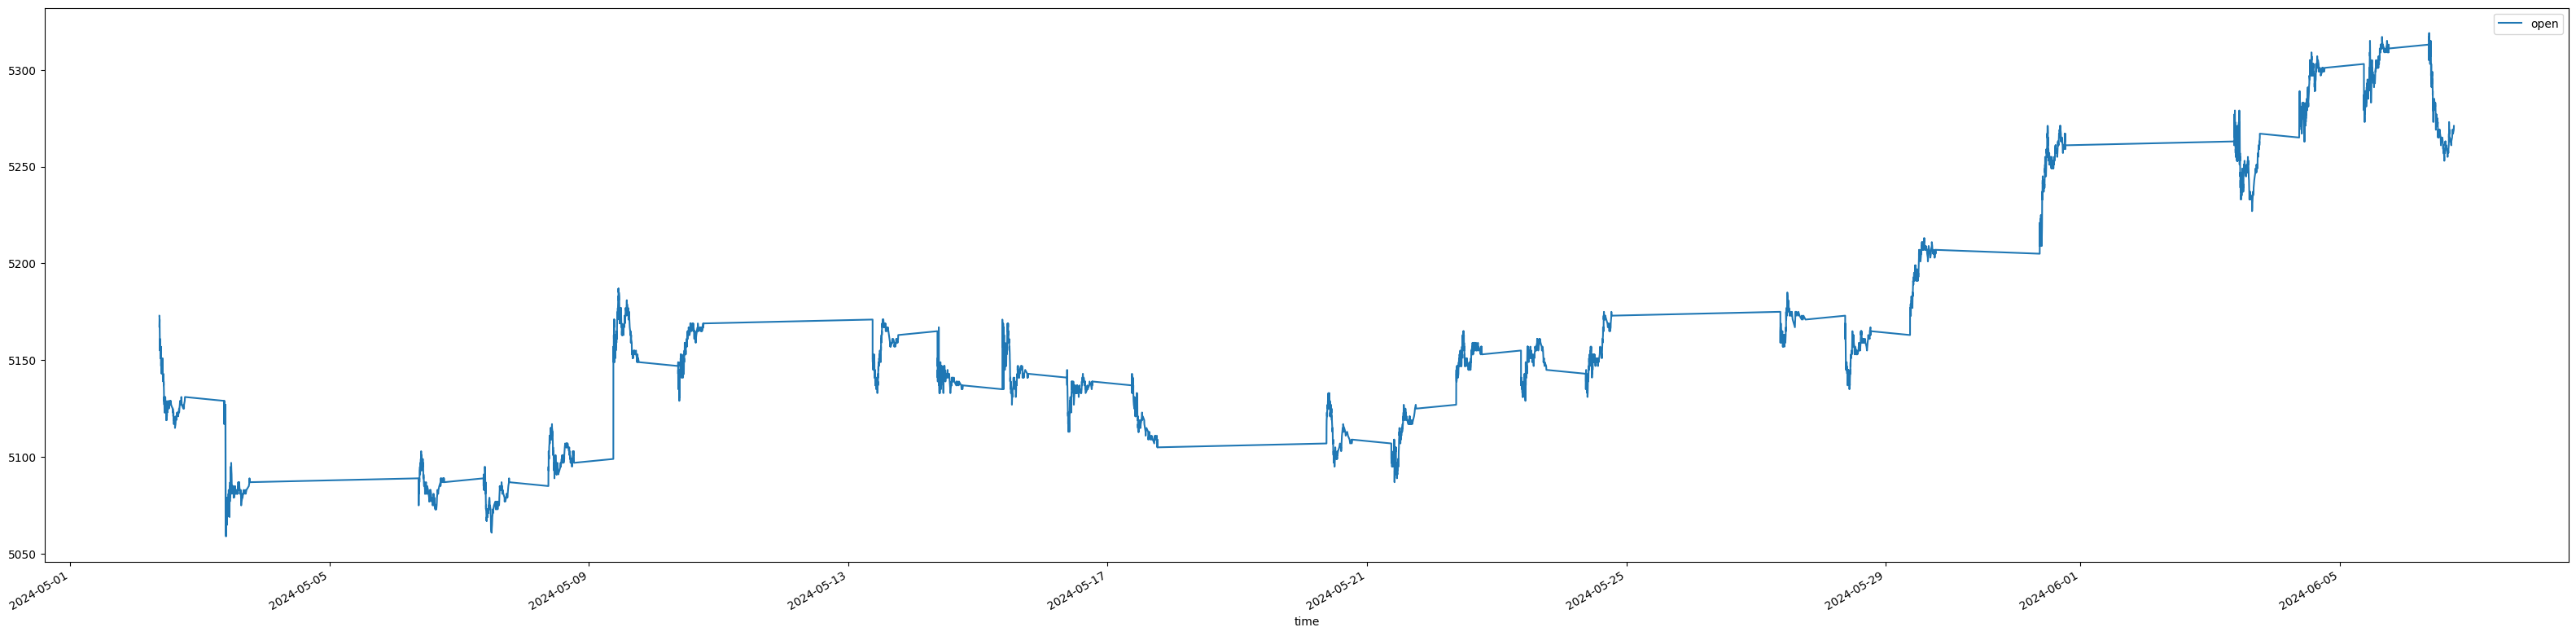

In [10]:
range = Range(brick_size=brick_size, times=rates.index.values, prices=rates["Open"])
range_oc = pd.DataFrame(range.bricks)
range_oc.index = range_oc["time"]
range_oc.drop(columns=["time"], inplace=True)
range_oc[["open"]].plot(figsize=(40,10))

range_oc["Open"] = range_oc["open"]
range_oc["Close"] = range_oc["close"]

range_oc.drop(columns=["open", "close"], inplace=True)

for i, item in range_oc.iterrows(): 
    range_oc["High"] = max(item["Open"], item["Close"])
    range_oc["Low"] = min(item["Open"], item["Close"])  

range_oc.to_excel("output.xlsx")

range_oc

In [11]:
class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(range_oc, SmaCross, exclusive_orders=True)
stats = bt.run()
#bt.plot()

stats

Start                     2024-05-02 09:03:14
End                       2024-06-06 18:19:10
Duration                     35 days 09:15:56
Exposure Time [%]                   98.555537
Equity Final [$]                      10134.0
Equity Peak [$]                       10250.0
Return [%]                               1.34
Buy & Hold Return [%]                 1.85579
Return (Ann.) [%]                   13.899219
Volatility (Ann.) [%]                5.016905
Sharpe Ratio                         2.770477
Sortino Ratio                        5.247576
Calmar Ratio                           9.1325
Max. Drawdown [%]                   -1.521951
Avg. Drawdown [%]                   -0.106837
Max. Drawdown Duration        9 days 01:25:24
Avg. Drawdown Duration        0 days 10:22:01
# Trades                                  192
Win Rate [%]                             37.5
Best Trade [%]                       0.979816
Worst Trade [%]                     -0.620035
Avg. Trade [%]                    